# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [105]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [3]:
def show_average_images(train_loader, test_loader, dataset, labels):
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
        
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


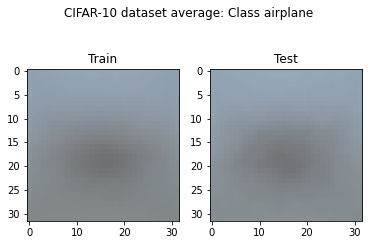

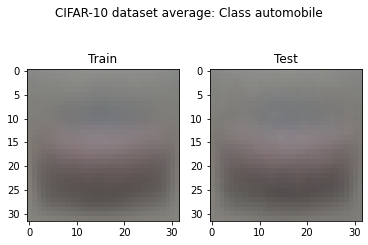

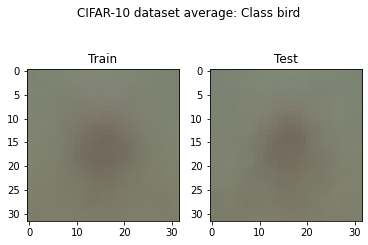

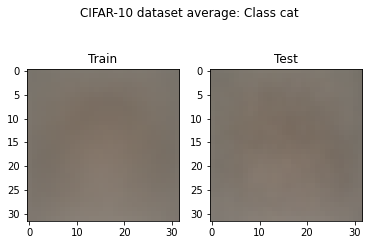

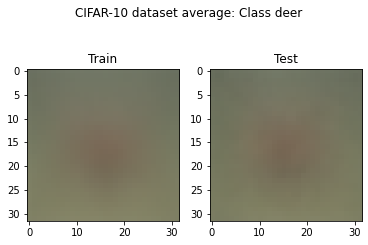

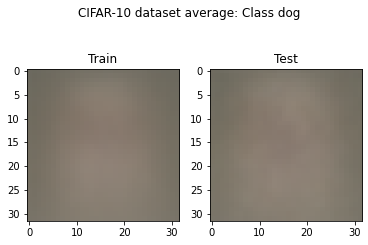

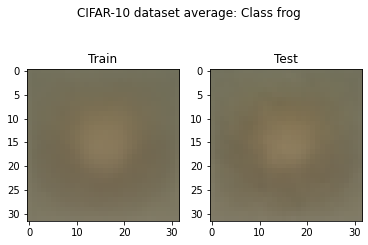

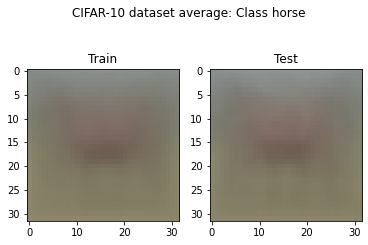

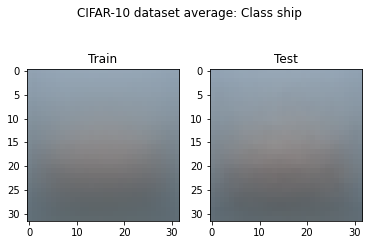

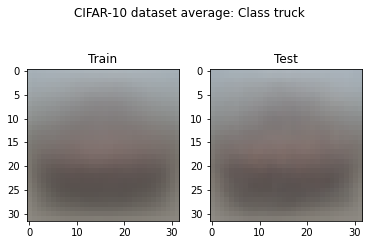

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


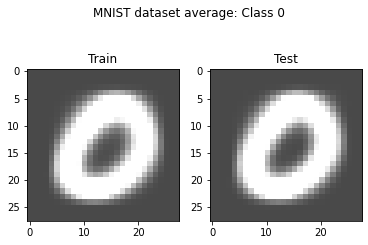

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


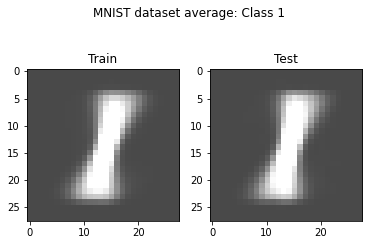

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


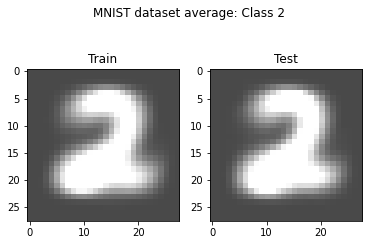

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


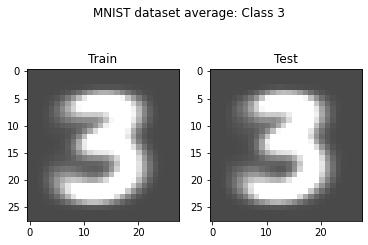

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


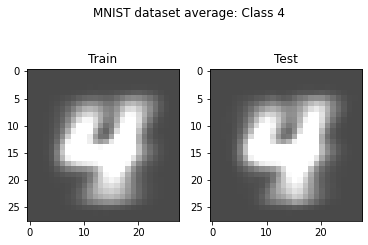

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


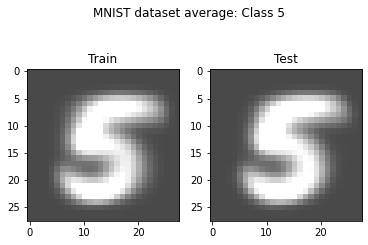

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


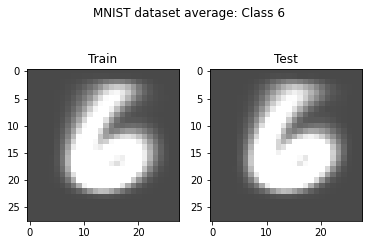

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


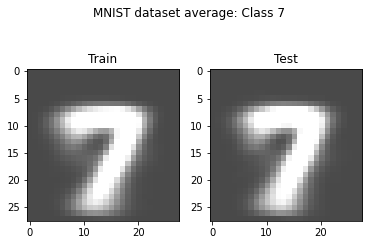

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


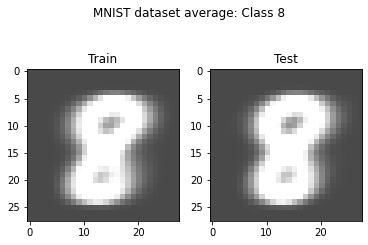

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


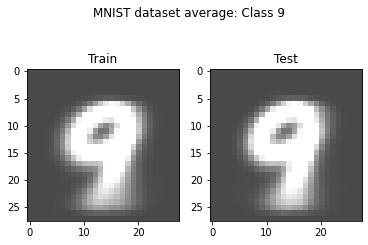

In [4]:
torch.utils.data.DataLoader.num_worker = 0

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'MNIST', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [5]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [6]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [7]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [8]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.245047
Train Epoch: 1 [100/60000 (0%)]	Loss: 3.246238
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.367375
Train Epoch: 1 [300/60000 (0%)]	Loss: 0.170358
Train Epoch: 1 [400/60000 (1%)]	Loss: 0.001140
Train Epoch: 1 [500/60000 (1%)]	Loss: 3.749475
Train Epoch: 1 [600/60000 (1%)]	Loss: 0.000079
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.128893
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.722579
Train Epoch: 1 [900/60000 (2%)]	Loss: 0.655062
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.004159
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.000476
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.000119
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.000281
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.019593
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.073192
Train Epoch: 1 [1600/60000 (3%)]	Loss: 4.916663
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.000171
Train Epoch: 1 [1800/60000 (3%)]	Loss: 11.780502
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.000025
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.000391
Tra

Train Epoch: 1 [16800/60000 (28%)]	Loss: 0.000000
Train Epoch: 1 [16900/60000 (28%)]	Loss: 17.932224
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.000511
Train Epoch: 1 [17100/60000 (28%)]	Loss: 0.897072
Train Epoch: 1 [17200/60000 (29%)]	Loss: 1.233004
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.002943
Train Epoch: 1 [17400/60000 (29%)]	Loss: 25.984859
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.000020
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000082
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.000004
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.000032
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.001234
Train Epoch: 1 [18200/60000 (30%)]	Loss: 0.002536
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.000064
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.000637
Train Epoch: 1 [18500/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.000006
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.02636

Train Epoch: 1 [33500/60000 (56%)]	Loss: 0.000000
Train Epoch: 1 [33600/60000 (56%)]	Loss: 0.000996
Train Epoch: 1 [33700/60000 (56%)]	Loss: 0.000008
Train Epoch: 1 [33800/60000 (56%)]	Loss: 6.873703
Train Epoch: 1 [33900/60000 (56%)]	Loss: 0.005514
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34100/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.000001
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.056628
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34800/60000 (58%)]	Loss: 0.000116
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.001520
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.573323
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.002371
Train Epoch: 1 [35300/60000 (59%)]	Loss: 0.060748
Train Epoch: 1 [35400/60000 (59%)]	Loss: 0.000049


Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.413290
Train Epoch: 1 [50100/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50200/60000 (84%)]	Loss: 0.042863
Train Epoch: 1 [50300/60000 (84%)]	Loss: 0.002735
Train Epoch: 1 [50400/60000 (84%)]	Loss: 2.010887
Train Epoch: 1 [50500/60000 (84%)]	Loss: 0.000267
Train Epoch: 1 [50600/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.006345
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.313522
Train Epoch: 1 [50900/60000 (85%)]	Loss: 0.000008
Train Epoch: 1 [51000/60000 (85%)]	Loss: 0.008719
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.041843
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.000002
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.509154
Train Epoch: 1 [51500/60000 (86%)]	Loss: 0.142827
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51700/60000 (86%)]	Loss: 1.694058
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.000456
Train Epoch: 1 [51900/60000 (86%)]	Loss: 0.000000


Train Epoch: 2 [7000/60000 (12%)]	Loss: 0.000006
Train Epoch: 2 [7100/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7200/60000 (12%)]	Loss: 5.442461
Train Epoch: 2 [7300/60000 (12%)]	Loss: 0.012733
Train Epoch: 2 [7400/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7600/60000 (13%)]	Loss: 0.000002
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.000001
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.008232
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.177947
Train Epoch: 2 [8000/60000 (13%)]	Loss: 10.238828
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.325173
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.000253
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.002791
Train Epoch: 2 [8500/60000 (14%)]	Loss: 10.697381
Train Epoch: 2 [8600/60000 (14%)]	Loss: 0.000002
Train Epoch: 2 [8700/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8800/60000 (15%)]	Loss: 0.003845
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [90

Train Epoch: 2 [23500/60000 (39%)]	Loss: 0.000047
Train Epoch: 2 [23600/60000 (39%)]	Loss: 0.024693
Train Epoch: 2 [23700/60000 (40%)]	Loss: 0.000021
Train Epoch: 2 [23800/60000 (40%)]	Loss: 0.000028
Train Epoch: 2 [23900/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.009704
Train Epoch: 2 [24200/60000 (40%)]	Loss: 25.384367
Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24400/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24500/60000 (41%)]	Loss: 3.781302
Train Epoch: 2 [24600/60000 (41%)]	Loss: 3.043464
Train Epoch: 2 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.004349
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.000001
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000025
Train Epoch: 2 [25200/60000 (42%)]	Loss: 1.878650
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.005840

Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000001
Train Epoch: 2 [40100/60000 (67%)]	Loss: 0.000000
Train Epoch: 2 [40200/60000 (67%)]	Loss: 0.000000
Train Epoch: 2 [40300/60000 (67%)]	Loss: 1.232731
Train Epoch: 2 [40400/60000 (67%)]	Loss: 0.000000
Train Epoch: 2 [40500/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [40600/60000 (68%)]	Loss: 27.875231
Train Epoch: 2 [40700/60000 (68%)]	Loss: 4.592059
Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.000098
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.028185
Train Epoch: 2 [41200/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.509346
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.000010
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.000013
Train Epoch: 2 [41700/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41900/60000 (70%)]	Loss: 0.000045

Train Epoch: 2 [56600/60000 (94%)]	Loss: 0.000000
Train Epoch: 2 [56700/60000 (94%)]	Loss: 0.000884
Train Epoch: 2 [56800/60000 (95%)]	Loss: 0.000312
Train Epoch: 2 [56900/60000 (95%)]	Loss: 0.000000
Train Epoch: 2 [57000/60000 (95%)]	Loss: 2.609084
Train Epoch: 2 [57100/60000 (95%)]	Loss: 11.865281
Train Epoch: 2 [57200/60000 (95%)]	Loss: 0.000003
Train Epoch: 2 [57300/60000 (96%)]	Loss: 0.001437
Train Epoch: 2 [57400/60000 (96%)]	Loss: 0.182466
Train Epoch: 2 [57500/60000 (96%)]	Loss: 24.444262
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000005
Train Epoch: 2 [57700/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.000001
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.000096
Train Epoch: 2 [58000/60000 (97%)]	Loss: 2.486187
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58200/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.158212
Train Epoch: 2 [58400/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.00158

Train Epoch: 3 [13400/60000 (22%)]	Loss: 0.000000
Train Epoch: 3 [13500/60000 (22%)]	Loss: 0.000000
Train Epoch: 3 [13600/60000 (23%)]	Loss: 0.000000
Train Epoch: 3 [13700/60000 (23%)]	Loss: 0.000004
Train Epoch: 3 [13800/60000 (23%)]	Loss: 0.000000
Train Epoch: 3 [13900/60000 (23%)]	Loss: 0.005163
Train Epoch: 3 [14000/60000 (23%)]	Loss: 0.000067
Train Epoch: 3 [14100/60000 (24%)]	Loss: 0.240560
Train Epoch: 3 [14200/60000 (24%)]	Loss: 0.578189
Train Epoch: 3 [14300/60000 (24%)]	Loss: 0.000000
Train Epoch: 3 [14400/60000 (24%)]	Loss: 0.000486
Train Epoch: 3 [14500/60000 (24%)]	Loss: 0.000001
Train Epoch: 3 [14600/60000 (24%)]	Loss: 1.493793
Train Epoch: 3 [14700/60000 (24%)]	Loss: 0.000002
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [14900/60000 (25%)]	Loss: 0.000055
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.000010
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.000004
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.000002
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000024


Train Epoch: 3 [29900/60000 (50%)]	Loss: 0.000000
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.000000
Train Epoch: 3 [30100/60000 (50%)]	Loss: 0.001210
Train Epoch: 3 [30200/60000 (50%)]	Loss: 0.000171
Train Epoch: 3 [30300/60000 (50%)]	Loss: 0.000220
Train Epoch: 3 [30400/60000 (51%)]	Loss: 0.000015
Train Epoch: 3 [30500/60000 (51%)]	Loss: 0.000002
Train Epoch: 3 [30600/60000 (51%)]	Loss: 0.000004
Train Epoch: 3 [30700/60000 (51%)]	Loss: 0.011548
Train Epoch: 3 [30800/60000 (51%)]	Loss: 0.938087
Train Epoch: 3 [30900/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31000/60000 (52%)]	Loss: 0.000004
Train Epoch: 3 [31100/60000 (52%)]	Loss: 0.000026
Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.000350
Train Epoch: 3 [31300/60000 (52%)]	Loss: 6.288107
Train Epoch: 3 [31400/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31500/60000 (52%)]	Loss: 0.000046
Train Epoch: 3 [31600/60000 (53%)]	Loss: 7.747334
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.000000


Train Epoch: 3 [46300/60000 (77%)]	Loss: 0.000000
Train Epoch: 3 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 3 [46500/60000 (78%)]	Loss: 0.000000
Train Epoch: 3 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 3 [46700/60000 (78%)]	Loss: 0.000090
Train Epoch: 3 [46800/60000 (78%)]	Loss: 0.000002
Train Epoch: 3 [46900/60000 (78%)]	Loss: 0.001556
Train Epoch: 3 [47000/60000 (78%)]	Loss: 0.100197
Train Epoch: 3 [47100/60000 (78%)]	Loss: 0.000000
Train Epoch: 3 [47200/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47300/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47400/60000 (79%)]	Loss: 0.022681
Train Epoch: 3 [47500/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47600/60000 (79%)]	Loss: 0.027637
Train Epoch: 3 [47700/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [47800/60000 (80%)]	Loss: 0.000014
Train Epoch: 3 [47900/60000 (80%)]	Loss: 4.951827
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.000941
Train Epoch: 3 [48200/60000 (80%)]	Loss: 0.000000


Train Epoch: 4 [2900/60000 (5%)]	Loss: 4.432761
Train Epoch: 4 [3000/60000 (5%)]	Loss: 0.000002
Train Epoch: 4 [3100/60000 (5%)]	Loss: 0.000000
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.000000
Train Epoch: 4 [3300/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [3400/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [3500/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [3600/60000 (6%)]	Loss: 0.002747
Train Epoch: 4 [3700/60000 (6%)]	Loss: 0.000061
Train Epoch: 4 [3800/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [3900/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [4000/60000 (7%)]	Loss: 0.000001
Train Epoch: 4 [4100/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4200/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4300/60000 (7%)]	Loss: 3.499089
Train Epoch: 4 [4400/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4500/60000 (8%)]	Loss: 0.000021
Train Epoch: 4 [4600/60000 (8%)]	Loss: 0.000045
Train Epoch: 4 [4700/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4900/60000 (8%)]	Loss: 0

Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.000010
Train Epoch: 4 [20100/60000 (34%)]	Loss: 6.492045
Train Epoch: 4 [20200/60000 (34%)]	Loss: 0.000008
Train Epoch: 4 [20300/60000 (34%)]	Loss: 0.000000
Train Epoch: 4 [20400/60000 (34%)]	Loss: 0.373607
Train Epoch: 4 [20500/60000 (34%)]	Loss: 0.000003
Train Epoch: 4 [20600/60000 (34%)]	Loss: 0.000024
Train Epoch: 4 [20700/60000 (34%)]	Loss: 0.000280
Train Epoch: 4 [20800/60000 (35%)]	Loss: 13.200008
Train Epoch: 4 [20900/60000 (35%)]	Loss: 0.000024
Train Epoch: 4 [21000/60000 (35%)]	Loss: 0.000000
Train Epoch: 4 [21100/60000 (35%)]	Loss: 0.000290
Train Epoch: 4 [21200/60000 (35%)]	Loss: 0.002638
Train Epoch: 4 [21300/60000 (36%)]	Loss: 20.659863
Train Epoch: 4 [21400/60000 (36%)]	Loss: 0.030188
Train Epoch: 4 [21500/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21600/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21700/60000 (36%)]	Loss: 10.503040
Train Epoch: 4 [21800/60000 (36%)]	Loss: 0.014703
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.0001

Train Epoch: 4 [36400/60000 (61%)]	Loss: 0.000031
Train Epoch: 4 [36500/60000 (61%)]	Loss: 0.000008
Train Epoch: 4 [36600/60000 (61%)]	Loss: 2.090519
Train Epoch: 4 [36700/60000 (61%)]	Loss: 0.000000
Train Epoch: 4 [36800/60000 (61%)]	Loss: 0.000182
Train Epoch: 4 [36900/60000 (62%)]	Loss: 0.265555
Train Epoch: 4 [37000/60000 (62%)]	Loss: 10.514012
Train Epoch: 4 [37100/60000 (62%)]	Loss: 0.000000
Train Epoch: 4 [37200/60000 (62%)]	Loss: 0.000000
Train Epoch: 4 [37300/60000 (62%)]	Loss: 0.000000
Train Epoch: 4 [37400/60000 (62%)]	Loss: 0.000003
Train Epoch: 4 [37500/60000 (62%)]	Loss: 2.090255
Train Epoch: 4 [37600/60000 (63%)]	Loss: 14.803489
Train Epoch: 4 [37700/60000 (63%)]	Loss: 0.004665
Train Epoch: 4 [37800/60000 (63%)]	Loss: 0.000002
Train Epoch: 4 [37900/60000 (63%)]	Loss: 1.835451
Train Epoch: 4 [38000/60000 (63%)]	Loss: 0.000000
Train Epoch: 4 [38100/60000 (64%)]	Loss: 18.686581
Train Epoch: 4 [38200/60000 (64%)]	Loss: 0.000002
Train Epoch: 4 [38300/60000 (64%)]	Loss: 0.0069

Train Epoch: 4 [52800/60000 (88%)]	Loss: 0.000000
Train Epoch: 4 [52900/60000 (88%)]	Loss: 0.000792
Train Epoch: 4 [53000/60000 (88%)]	Loss: 0.000091
Train Epoch: 4 [53100/60000 (88%)]	Loss: 0.000000
Train Epoch: 4 [53200/60000 (89%)]	Loss: 0.000000
Train Epoch: 4 [53300/60000 (89%)]	Loss: 0.157232
Train Epoch: 4 [53400/60000 (89%)]	Loss: 2.755332
Train Epoch: 4 [53500/60000 (89%)]	Loss: 4.563477
Train Epoch: 4 [53600/60000 (89%)]	Loss: 1.596361
Train Epoch: 4 [53700/60000 (90%)]	Loss: 0.767804
Train Epoch: 4 [53800/60000 (90%)]	Loss: 0.000000
Train Epoch: 4 [53900/60000 (90%)]	Loss: 0.000022
Train Epoch: 4 [54000/60000 (90%)]	Loss: 7.839170
Train Epoch: 4 [54100/60000 (90%)]	Loss: 0.000001
Train Epoch: 4 [54200/60000 (90%)]	Loss: 0.069194
Train Epoch: 4 [54300/60000 (90%)]	Loss: 0.000000
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.000247
Train Epoch: 4 [54500/60000 (91%)]	Loss: 1.864023
Train Epoch: 4 [54600/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54700/60000 (91%)]	Loss: 0.000000


Train Epoch: 5 [9800/60000 (16%)]	Loss: 0.000000
Train Epoch: 5 [9900/60000 (16%)]	Loss: 0.000000
Train Epoch: 5 [10000/60000 (17%)]	Loss: 3.556098
Train Epoch: 5 [10100/60000 (17%)]	Loss: 0.000118
Train Epoch: 5 [10200/60000 (17%)]	Loss: 0.000000
Train Epoch: 5 [10300/60000 (17%)]	Loss: 0.000000
Train Epoch: 5 [10400/60000 (17%)]	Loss: 0.038567
Train Epoch: 5 [10500/60000 (18%)]	Loss: 8.375243
Train Epoch: 5 [10600/60000 (18%)]	Loss: 0.000000
Train Epoch: 5 [10700/60000 (18%)]	Loss: 0.000035
Train Epoch: 5 [10800/60000 (18%)]	Loss: 0.038055
Train Epoch: 5 [10900/60000 (18%)]	Loss: 0.000002
Train Epoch: 5 [11000/60000 (18%)]	Loss: 0.002903
Train Epoch: 5 [11100/60000 (18%)]	Loss: 6.489708
Train Epoch: 5 [11200/60000 (19%)]	Loss: 0.000344
Train Epoch: 5 [11300/60000 (19%)]	Loss: 35.015148
Train Epoch: 5 [11400/60000 (19%)]	Loss: 0.000000
Train Epoch: 5 [11500/60000 (19%)]	Loss: 0.000282
Train Epoch: 5 [11600/60000 (19%)]	Loss: 0.000043
Train Epoch: 5 [11700/60000 (20%)]	Loss: 0.000128
T

Train Epoch: 5 [26600/60000 (44%)]	Loss: 0.000042
Train Epoch: 5 [26700/60000 (44%)]	Loss: 0.000000
Train Epoch: 5 [26800/60000 (45%)]	Loss: 0.000000
Train Epoch: 5 [26900/60000 (45%)]	Loss: 0.000000
Train Epoch: 5 [27000/60000 (45%)]	Loss: 0.020446
Train Epoch: 5 [27100/60000 (45%)]	Loss: 0.207882
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.020587
Train Epoch: 5 [27300/60000 (46%)]	Loss: 0.000010
Train Epoch: 5 [27400/60000 (46%)]	Loss: 0.000000
Train Epoch: 5 [27500/60000 (46%)]	Loss: 0.000115
Train Epoch: 5 [27600/60000 (46%)]	Loss: 6.873863
Train Epoch: 5 [27700/60000 (46%)]	Loss: 0.000000
Train Epoch: 5 [27800/60000 (46%)]	Loss: 1.850687
Train Epoch: 5 [27900/60000 (46%)]	Loss: 0.000038
Train Epoch: 5 [28000/60000 (47%)]	Loss: 0.000000
Train Epoch: 5 [28100/60000 (47%)]	Loss: 0.000332
Train Epoch: 5 [28200/60000 (47%)]	Loss: 0.000000
Train Epoch: 5 [28300/60000 (47%)]	Loss: 0.000000
Train Epoch: 5 [28400/60000 (47%)]	Loss: 0.000003
Train Epoch: 5 [28500/60000 (48%)]	Loss: 0.000083


Train Epoch: 5 [43300/60000 (72%)]	Loss: 0.000000
Train Epoch: 5 [43400/60000 (72%)]	Loss: 0.000010
Train Epoch: 5 [43500/60000 (72%)]	Loss: 0.000000
Train Epoch: 5 [43600/60000 (73%)]	Loss: 0.000760
Train Epoch: 5 [43700/60000 (73%)]	Loss: 0.000002
Train Epoch: 5 [43800/60000 (73%)]	Loss: 0.000345
Train Epoch: 5 [43900/60000 (73%)]	Loss: 0.060545
Train Epoch: 5 [44000/60000 (73%)]	Loss: 0.000000
Train Epoch: 5 [44100/60000 (74%)]	Loss: 0.000000
Train Epoch: 5 [44200/60000 (74%)]	Loss: 0.036519
Train Epoch: 5 [44300/60000 (74%)]	Loss: 0.000000
Train Epoch: 5 [44400/60000 (74%)]	Loss: 0.000000
Train Epoch: 5 [44500/60000 (74%)]	Loss: 0.000044
Train Epoch: 5 [44600/60000 (74%)]	Loss: 0.000000
Train Epoch: 5 [44700/60000 (74%)]	Loss: 0.012403
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000000
Train Epoch: 5 [44900/60000 (75%)]	Loss: 0.000000
Train Epoch: 5 [45000/60000 (75%)]	Loss: 0.000000
Train Epoch: 5 [45100/60000 (75%)]	Loss: 1.934682
Train Epoch: 5 [45200/60000 (75%)]	Loss: 0.003671


Train Epoch: 5 [59900/60000 (100%)]	Loss: 0.000000
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.021609
Train Epoch: 6 [100/60000 (0%)]	Loss: 0.001185
Train Epoch: 6 [200/60000 (0%)]	Loss: 0.000046
Train Epoch: 6 [300/60000 (0%)]	Loss: 0.000002
Train Epoch: 6 [400/60000 (1%)]	Loss: 0.000000
Train Epoch: 6 [500/60000 (1%)]	Loss: 0.003439
Train Epoch: 6 [600/60000 (1%)]	Loss: 0.000006
Train Epoch: 6 [700/60000 (1%)]	Loss: 0.000000
Train Epoch: 6 [800/60000 (1%)]	Loss: 0.000071
Train Epoch: 6 [900/60000 (2%)]	Loss: 0.000000
Train Epoch: 6 [1000/60000 (2%)]	Loss: 0.000000
Train Epoch: 6 [1100/60000 (2%)]	Loss: 8.034908
Train Epoch: 6 [1200/60000 (2%)]	Loss: 0.008003
Train Epoch: 6 [1300/60000 (2%)]	Loss: 7.113229
Train Epoch: 6 [1400/60000 (2%)]	Loss: 0.000000
Train Epoch: 6 [1500/60000 (2%)]	Loss: 0.000002
Train Epoch: 6 [1600/60000 (3%)]	Loss: 0.000023
Train Epoch: 6 [1700/60000 (3%)]	Loss: 0.000000
Train Epoch: 6 [1800/60000 (3%)]	Loss: 0.000000
Train Epoch: 6 [1900/60000 (3%)]	Loss: 5.705513
T

Train Epoch: 6 [16900/60000 (28%)]	Loss: 0.000000
Train Epoch: 6 [17000/60000 (28%)]	Loss: 3.213317
Train Epoch: 6 [17100/60000 (28%)]	Loss: 0.000001
Train Epoch: 6 [17200/60000 (29%)]	Loss: 14.289280
Train Epoch: 6 [17300/60000 (29%)]	Loss: 0.000011
Train Epoch: 6 [17400/60000 (29%)]	Loss: 0.000001
Train Epoch: 6 [17500/60000 (29%)]	Loss: 0.000001
Train Epoch: 6 [17600/60000 (29%)]	Loss: 0.000000
Train Epoch: 6 [17700/60000 (30%)]	Loss: 0.000084
Train Epoch: 6 [17800/60000 (30%)]	Loss: 0.000000
Train Epoch: 6 [17900/60000 (30%)]	Loss: 0.000385
Train Epoch: 6 [18000/60000 (30%)]	Loss: 0.013754
Train Epoch: 6 [18100/60000 (30%)]	Loss: 0.000201
Train Epoch: 6 [18200/60000 (30%)]	Loss: 4.923539
Train Epoch: 6 [18300/60000 (30%)]	Loss: 0.000060
Train Epoch: 6 [18400/60000 (31%)]	Loss: 7.269299
Train Epoch: 6 [18500/60000 (31%)]	Loss: 0.000000
Train Epoch: 6 [18600/60000 (31%)]	Loss: 0.031285
Train Epoch: 6 [18700/60000 (31%)]	Loss: 0.000000
Train Epoch: 6 [18800/60000 (31%)]	Loss: 0.000005

Train Epoch: 6 [33500/60000 (56%)]	Loss: 0.868135
Train Epoch: 6 [33600/60000 (56%)]	Loss: 0.000306
Train Epoch: 6 [33700/60000 (56%)]	Loss: 0.000000
Train Epoch: 6 [33800/60000 (56%)]	Loss: 0.000000
Train Epoch: 6 [33900/60000 (56%)]	Loss: 0.000008
Train Epoch: 6 [34000/60000 (57%)]	Loss: 0.000000
Train Epoch: 6 [34100/60000 (57%)]	Loss: 0.000000
Train Epoch: 6 [34200/60000 (57%)]	Loss: 31.566090
Train Epoch: 6 [34300/60000 (57%)]	Loss: 0.000000
Train Epoch: 6 [34400/60000 (57%)]	Loss: 0.000000
Train Epoch: 6 [34500/60000 (58%)]	Loss: 0.000019
Train Epoch: 6 [34600/60000 (58%)]	Loss: 0.000000
Train Epoch: 6 [34700/60000 (58%)]	Loss: 0.000013
Train Epoch: 6 [34800/60000 (58%)]	Loss: 0.000003
Train Epoch: 6 [34900/60000 (58%)]	Loss: 0.000000
Train Epoch: 6 [35000/60000 (58%)]	Loss: 15.861804
Train Epoch: 6 [35100/60000 (58%)]	Loss: 0.000000
Train Epoch: 6 [35200/60000 (59%)]	Loss: 0.003471
Train Epoch: 6 [35300/60000 (59%)]	Loss: 0.598629
Train Epoch: 6 [35400/60000 (59%)]	Loss: 0.00006

Train Epoch: 6 [50000/60000 (83%)]	Loss: 0.000080
Train Epoch: 6 [50100/60000 (84%)]	Loss: 0.000000
Train Epoch: 6 [50200/60000 (84%)]	Loss: 0.000000
Train Epoch: 6 [50300/60000 (84%)]	Loss: 11.377658
Train Epoch: 6 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 6 [50500/60000 (84%)]	Loss: 0.000001
Train Epoch: 6 [50600/60000 (84%)]	Loss: 0.000002
Train Epoch: 6 [50700/60000 (84%)]	Loss: 0.000065
Train Epoch: 6 [50800/60000 (85%)]	Loss: 0.000000
Train Epoch: 6 [50900/60000 (85%)]	Loss: 0.002170
Train Epoch: 6 [51000/60000 (85%)]	Loss: 0.000000
Train Epoch: 6 [51100/60000 (85%)]	Loss: 0.000023
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000001
Train Epoch: 6 [51300/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51400/60000 (86%)]	Loss: 0.057161
Train Epoch: 6 [51500/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51600/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51700/60000 (86%)]	Loss: 3.847827
Train Epoch: 6 [51800/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51900/60000 (86%)]	Loss: 0.056214

Train Epoch: 7 [7200/60000 (12%)]	Loss: 0.062094
Train Epoch: 7 [7300/60000 (12%)]	Loss: 0.000000
Train Epoch: 7 [7400/60000 (12%)]	Loss: 0.000001
Train Epoch: 7 [7500/60000 (12%)]	Loss: 9.872468
Train Epoch: 7 [7600/60000 (13%)]	Loss: 0.000000
Train Epoch: 7 [7700/60000 (13%)]	Loss: 0.101430
Train Epoch: 7 [7800/60000 (13%)]	Loss: 0.000269
Train Epoch: 7 [7900/60000 (13%)]	Loss: 0.000000
Train Epoch: 7 [8000/60000 (13%)]	Loss: 0.000000
Train Epoch: 7 [8100/60000 (14%)]	Loss: 0.000001
Train Epoch: 7 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 7 [8300/60000 (14%)]	Loss: 0.000107
Train Epoch: 7 [8400/60000 (14%)]	Loss: 0.000002
Train Epoch: 7 [8500/60000 (14%)]	Loss: 0.000003
Train Epoch: 7 [8600/60000 (14%)]	Loss: 0.000001
Train Epoch: 7 [8700/60000 (14%)]	Loss: 3.220633
Train Epoch: 7 [8800/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [8900/60000 (15%)]	Loss: 0.071534
Train Epoch: 7 [9000/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [9100/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [9200

Train Epoch: 7 [23900/60000 (40%)]	Loss: 0.015334
Train Epoch: 7 [24000/60000 (40%)]	Loss: 0.000020
Train Epoch: 7 [24100/60000 (40%)]	Loss: 0.056337
Train Epoch: 7 [24200/60000 (40%)]	Loss: 0.002814
Train Epoch: 7 [24300/60000 (40%)]	Loss: 0.000000
Train Epoch: 7 [24400/60000 (41%)]	Loss: 0.000000
Train Epoch: 7 [24500/60000 (41%)]	Loss: 0.002397
Train Epoch: 7 [24600/60000 (41%)]	Loss: 0.000221
Train Epoch: 7 [24700/60000 (41%)]	Loss: 0.646967
Train Epoch: 7 [24800/60000 (41%)]	Loss: 0.001339
Train Epoch: 7 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25000/60000 (42%)]	Loss: 0.000042
Train Epoch: 7 [25100/60000 (42%)]	Loss: 0.003377
Train Epoch: 7 [25200/60000 (42%)]	Loss: 0.000138
Train Epoch: 7 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25400/60000 (42%)]	Loss: 0.000028
Train Epoch: 7 [25500/60000 (42%)]	Loss: 1.122908
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [25700/60000 (43%)]	Loss: 0.000001
Train Epoch: 7 [25800/60000 (43%)]	Loss: 0.061396


Train Epoch: 7 [40600/60000 (68%)]	Loss: 0.000000
Train Epoch: 7 [40700/60000 (68%)]	Loss: 0.000000
Train Epoch: 7 [40800/60000 (68%)]	Loss: 0.010354
Train Epoch: 7 [40900/60000 (68%)]	Loss: 1.617120
Train Epoch: 7 [41000/60000 (68%)]	Loss: 0.000037
Train Epoch: 7 [41100/60000 (68%)]	Loss: 0.001938
Train Epoch: 7 [41200/60000 (69%)]	Loss: 0.000000
Train Epoch: 7 [41300/60000 (69%)]	Loss: 0.000000
Train Epoch: 7 [41400/60000 (69%)]	Loss: 0.000000
Train Epoch: 7 [41500/60000 (69%)]	Loss: 0.030220
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.000000
Train Epoch: 7 [41700/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [41800/60000 (70%)]	Loss: 0.001005
Train Epoch: 7 [41900/60000 (70%)]	Loss: 0.000034
Train Epoch: 7 [42000/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42100/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42200/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42300/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42400/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42500/60000 (71%)]	Loss: 0.000000


Train Epoch: 7 [57300/60000 (96%)]	Loss: 0.000000
Train Epoch: 7 [57400/60000 (96%)]	Loss: 1.202735
Train Epoch: 7 [57500/60000 (96%)]	Loss: 0.000000
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000608
Train Epoch: 7 [57700/60000 (96%)]	Loss: 0.000460
Train Epoch: 7 [57800/60000 (96%)]	Loss: 0.000010
Train Epoch: 7 [57900/60000 (96%)]	Loss: 0.000000
Train Epoch: 7 [58000/60000 (97%)]	Loss: 0.000004
Train Epoch: 7 [58100/60000 (97%)]	Loss: 0.001008
Train Epoch: 7 [58200/60000 (97%)]	Loss: 0.000007
Train Epoch: 7 [58300/60000 (97%)]	Loss: 0.000116
Train Epoch: 7 [58400/60000 (97%)]	Loss: 0.000979
Train Epoch: 7 [58500/60000 (98%)]	Loss: 0.000031
Train Epoch: 7 [58600/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58700/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58900/60000 (98%)]	Loss: 0.000025
Train Epoch: 7 [59000/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [59100/60000 (98%)]	Loss: 0.000001
Train Epoch: 7 [59200/60000 (99%)]	Loss: 0.000056


Train Epoch: 8 [14600/60000 (24%)]	Loss: 0.000000
Train Epoch: 8 [14700/60000 (24%)]	Loss: 0.011718
Train Epoch: 8 [14800/60000 (25%)]	Loss: 0.016731
Train Epoch: 8 [14900/60000 (25%)]	Loss: 0.000000
Train Epoch: 8 [15000/60000 (25%)]	Loss: 0.000010
Train Epoch: 8 [15100/60000 (25%)]	Loss: 4.788569
Train Epoch: 8 [15200/60000 (25%)]	Loss: 0.000000
Train Epoch: 8 [15300/60000 (26%)]	Loss: 12.593915
Train Epoch: 8 [15400/60000 (26%)]	Loss: 6.856031
Train Epoch: 8 [15500/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15600/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15700/60000 (26%)]	Loss: 0.000058
Train Epoch: 8 [15800/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15900/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.000015
Train Epoch: 8 [16100/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16200/60000 (27%)]	Loss: 0.000009
Train Epoch: 8 [16300/60000 (27%)]	Loss: 0.000290
Train Epoch: 8 [16400/60000 (27%)]	Loss: 0.000053
Train Epoch: 8 [16500/60000 (28%)]	Loss: 0.000028

Train Epoch: 8 [31400/60000 (52%)]	Loss: 0.000000
Train Epoch: 8 [31500/60000 (52%)]	Loss: 0.000000
Train Epoch: 8 [31600/60000 (53%)]	Loss: 0.068123
Train Epoch: 8 [31700/60000 (53%)]	Loss: 0.001836
Train Epoch: 8 [31800/60000 (53%)]	Loss: 0.000014
Train Epoch: 8 [31900/60000 (53%)]	Loss: 0.000000
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000001
Train Epoch: 8 [32100/60000 (54%)]	Loss: 0.000000
Train Epoch: 8 [32200/60000 (54%)]	Loss: 0.000027
Train Epoch: 8 [32300/60000 (54%)]	Loss: 16.802437
Train Epoch: 8 [32400/60000 (54%)]	Loss: 0.011311
Train Epoch: 8 [32500/60000 (54%)]	Loss: 0.000000
Train Epoch: 8 [32600/60000 (54%)]	Loss: 0.000745
Train Epoch: 8 [32700/60000 (54%)]	Loss: 0.000000
Train Epoch: 8 [32800/60000 (55%)]	Loss: 0.012404
Train Epoch: 8 [32900/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33000/60000 (55%)]	Loss: 0.563273
Train Epoch: 8 [33100/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33200/60000 (55%)]	Loss: 0.000054
Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.055347

Train Epoch: 8 [48100/60000 (80%)]	Loss: 5.266662
Train Epoch: 8 [48200/60000 (80%)]	Loss: 1.270217
Train Epoch: 8 [48300/60000 (80%)]	Loss: 1.030794
Train Epoch: 8 [48400/60000 (81%)]	Loss: 0.000000
Train Epoch: 8 [48500/60000 (81%)]	Loss: 0.000000
Train Epoch: 8 [48600/60000 (81%)]	Loss: 0.001232
Train Epoch: 8 [48700/60000 (81%)]	Loss: 0.000395
Train Epoch: 8 [48800/60000 (81%)]	Loss: 10.213777
Train Epoch: 8 [48900/60000 (82%)]	Loss: 0.060022
Train Epoch: 8 [49000/60000 (82%)]	Loss: 0.000100
Train Epoch: 8 [49100/60000 (82%)]	Loss: 16.151573
Train Epoch: 8 [49200/60000 (82%)]	Loss: 0.000005
Train Epoch: 8 [49300/60000 (82%)]	Loss: 0.000000
Train Epoch: 8 [49400/60000 (82%)]	Loss: 12.945650
Train Epoch: 8 [49500/60000 (82%)]	Loss: 0.000397
Train Epoch: 8 [49600/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [49700/60000 (83%)]	Loss: 0.366810
Train Epoch: 8 [49800/60000 (83%)]	Loss: 0.000008
Train Epoch: 8 [49900/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.0000

Train Epoch: 9 [4700/60000 (8%)]	Loss: 4.768743
Train Epoch: 9 [4800/60000 (8%)]	Loss: 0.000358
Train Epoch: 9 [4900/60000 (8%)]	Loss: 0.023241
Train Epoch: 9 [5000/60000 (8%)]	Loss: 0.000000
Train Epoch: 9 [5100/60000 (8%)]	Loss: 0.000000
Train Epoch: 9 [5200/60000 (9%)]	Loss: 0.000891
Train Epoch: 9 [5300/60000 (9%)]	Loss: 0.000000
Train Epoch: 9 [5400/60000 (9%)]	Loss: 0.000067
Train Epoch: 9 [5500/60000 (9%)]	Loss: 0.065747
Train Epoch: 9 [5600/60000 (9%)]	Loss: 2.877180
Train Epoch: 9 [5700/60000 (10%)]	Loss: 0.000000
Train Epoch: 9 [5800/60000 (10%)]	Loss: 0.000000
Train Epoch: 9 [5900/60000 (10%)]	Loss: 0.000068
Train Epoch: 9 [6000/60000 (10%)]	Loss: 0.400379
Train Epoch: 9 [6100/60000 (10%)]	Loss: 0.000000
Train Epoch: 9 [6200/60000 (10%)]	Loss: 0.000072
Train Epoch: 9 [6300/60000 (10%)]	Loss: 0.000000
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6500/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6600/60000 (11%)]	Loss: 0.000006
Train Epoch: 9 [6700/60000 (11

Train Epoch: 9 [21500/60000 (36%)]	Loss: 0.007169
Train Epoch: 9 [21600/60000 (36%)]	Loss: 0.000000
Train Epoch: 9 [21700/60000 (36%)]	Loss: 0.000000
Train Epoch: 9 [21800/60000 (36%)]	Loss: 0.000104
Train Epoch: 9 [21900/60000 (36%)]	Loss: 0.000000
Train Epoch: 9 [22000/60000 (37%)]	Loss: 0.000719
Train Epoch: 9 [22100/60000 (37%)]	Loss: 2.058489
Train Epoch: 9 [22200/60000 (37%)]	Loss: 0.000000
Train Epoch: 9 [22300/60000 (37%)]	Loss: 0.000643
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.000011
Train Epoch: 9 [22500/60000 (38%)]	Loss: 0.000000
Train Epoch: 9 [22600/60000 (38%)]	Loss: 0.000017
Train Epoch: 9 [22700/60000 (38%)]	Loss: 0.000001
Train Epoch: 9 [22800/60000 (38%)]	Loss: 0.000000
Train Epoch: 9 [22900/60000 (38%)]	Loss: 0.000000
Train Epoch: 9 [23000/60000 (38%)]	Loss: 0.000000
Train Epoch: 9 [23100/60000 (38%)]	Loss: 0.332412
Train Epoch: 9 [23200/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23300/60000 (39%)]	Loss: 12.903857
Train Epoch: 9 [23400/60000 (39%)]	Loss: 0.000008

Train Epoch: 9 [38000/60000 (63%)]	Loss: 0.000164
Train Epoch: 9 [38100/60000 (64%)]	Loss: 0.000006
Train Epoch: 9 [38200/60000 (64%)]	Loss: 0.000000
Train Epoch: 9 [38300/60000 (64%)]	Loss: 0.000000
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000000
Train Epoch: 9 [38500/60000 (64%)]	Loss: 0.000000
Train Epoch: 9 [38600/60000 (64%)]	Loss: 0.000000
Train Epoch: 9 [38700/60000 (64%)]	Loss: 0.000003
Train Epoch: 9 [38800/60000 (65%)]	Loss: 0.000000
Train Epoch: 9 [38900/60000 (65%)]	Loss: 0.123716
Train Epoch: 9 [39000/60000 (65%)]	Loss: 0.000000
Train Epoch: 9 [39100/60000 (65%)]	Loss: 0.000021
Train Epoch: 9 [39200/60000 (65%)]	Loss: 0.000047
Train Epoch: 9 [39300/60000 (66%)]	Loss: 0.112957
Train Epoch: 9 [39400/60000 (66%)]	Loss: 2.010811
Train Epoch: 9 [39500/60000 (66%)]	Loss: 0.000554
Train Epoch: 9 [39600/60000 (66%)]	Loss: 8.595432
Train Epoch: 9 [39700/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39800/60000 (66%)]	Loss: 0.000006
Train Epoch: 9 [39900/60000 (66%)]	Loss: 0.000110


Train Epoch: 9 [54800/60000 (91%)]	Loss: 5.494703
Train Epoch: 9 [54900/60000 (92%)]	Loss: 0.010028
Train Epoch: 9 [55000/60000 (92%)]	Loss: 0.000165
Train Epoch: 9 [55100/60000 (92%)]	Loss: 0.000000
Train Epoch: 9 [55200/60000 (92%)]	Loss: 0.000000
Train Epoch: 9 [55300/60000 (92%)]	Loss: 0.000000
Train Epoch: 9 [55400/60000 (92%)]	Loss: 0.000000
Train Epoch: 9 [55500/60000 (92%)]	Loss: 2.048221
Train Epoch: 9 [55600/60000 (93%)]	Loss: 0.000038
Train Epoch: 9 [55700/60000 (93%)]	Loss: 0.000000
Train Epoch: 9 [55800/60000 (93%)]	Loss: 0.000000
Train Epoch: 9 [55900/60000 (93%)]	Loss: 0.000006
Train Epoch: 9 [56000/60000 (93%)]	Loss: 0.005034
Train Epoch: 9 [56100/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56200/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56300/60000 (94%)]	Loss: 0.000337
Train Epoch: 9 [56400/60000 (94%)]	Loss: 0.000004
Train Epoch: 9 [56500/60000 (94%)]	Loss: 0.000003
Train Epoch: 9 [56600/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56700/60000 (94%)]	Loss: 0.000000


Train Epoch: 10 [11600/60000 (19%)]	Loss: 0.000001
Train Epoch: 10 [11700/60000 (20%)]	Loss: 0.000000
Train Epoch: 10 [11800/60000 (20%)]	Loss: 0.000000
Train Epoch: 10 [11900/60000 (20%)]	Loss: 0.000000
Train Epoch: 10 [12000/60000 (20%)]	Loss: 0.001046
Train Epoch: 10 [12100/60000 (20%)]	Loss: 3.613275
Train Epoch: 10 [12200/60000 (20%)]	Loss: 0.000000
Train Epoch: 10 [12300/60000 (20%)]	Loss: 0.400429
Train Epoch: 10 [12400/60000 (21%)]	Loss: 0.000000
Train Epoch: 10 [12500/60000 (21%)]	Loss: 0.000895
Train Epoch: 10 [12600/60000 (21%)]	Loss: 0.000010
Train Epoch: 10 [12700/60000 (21%)]	Loss: 0.004164
Train Epoch: 10 [12800/60000 (21%)]	Loss: 2.010255
Train Epoch: 10 [12900/60000 (22%)]	Loss: 5.636605
Train Epoch: 10 [13000/60000 (22%)]	Loss: 2.278492
Train Epoch: 10 [13100/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13200/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13300/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13400/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13500/60000 (2

Train Epoch: 10 [28200/60000 (47%)]	Loss: 0.000000
Train Epoch: 10 [28300/60000 (47%)]	Loss: 0.000006
Train Epoch: 10 [28400/60000 (47%)]	Loss: 0.003907
Train Epoch: 10 [28500/60000 (48%)]	Loss: 0.000010
Train Epoch: 10 [28600/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [28700/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [28900/60000 (48%)]	Loss: 0.000001
Train Epoch: 10 [29000/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [29100/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [29200/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29300/60000 (49%)]	Loss: 0.305151
Train Epoch: 10 [29400/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29500/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29600/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29700/60000 (50%)]	Loss: 0.000003
Train Epoch: 10 [29800/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [29900/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30100/60000 (5

Train Epoch: 10 [44300/60000 (74%)]	Loss: 0.000097
Train Epoch: 10 [44400/60000 (74%)]	Loss: 10.413996
Train Epoch: 10 [44500/60000 (74%)]	Loss: 0.000049
Train Epoch: 10 [44600/60000 (74%)]	Loss: 0.000000
Train Epoch: 10 [44700/60000 (74%)]	Loss: 0.000827
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000000
Train Epoch: 10 [44900/60000 (75%)]	Loss: 0.000009
Train Epoch: 10 [45000/60000 (75%)]	Loss: 0.000068
Train Epoch: 10 [45100/60000 (75%)]	Loss: 0.000004
Train Epoch: 10 [45200/60000 (75%)]	Loss: 2.260280
Train Epoch: 10 [45300/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45400/60000 (76%)]	Loss: 0.003841
Train Epoch: 10 [45500/60000 (76%)]	Loss: 2.621298
Train Epoch: 10 [45600/60000 (76%)]	Loss: 0.037839
Train Epoch: 10 [45700/60000 (76%)]	Loss: 0.000284
Train Epoch: 10 [45800/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45900/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [46000/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46100/60000 (77%)]	Loss: 0.026973
Train Epoch: 10 [46200/60000 (

C:\Users\Karee\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


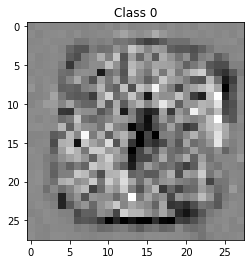

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


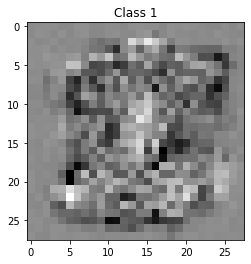

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


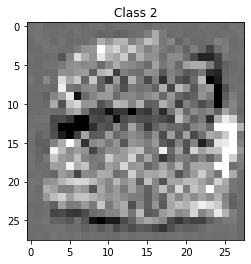

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


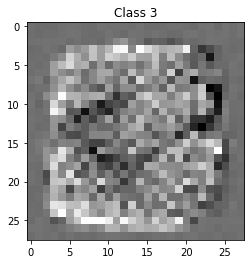

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


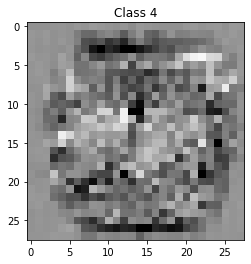

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


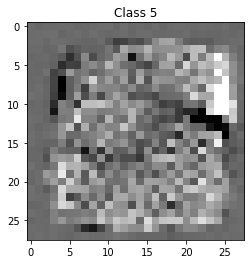

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


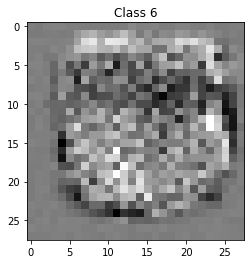

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


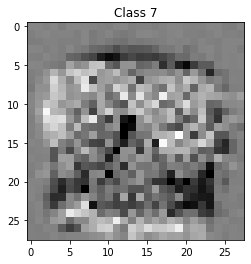

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


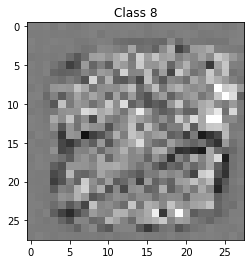

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


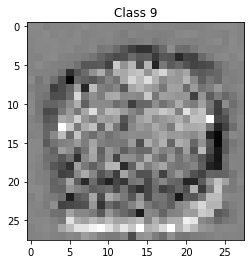

In [9]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp = temp / 2 + 0.5  # un-normalize
        temp_np = temp.numpy()
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [10]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(network.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
        
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.529259
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.420053
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.483454
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.433833
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.316206
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.384568
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.442796
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.585846
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.442808
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.365715

Test set: Average loss: 2.4594, Accuracy: 1037/10000 (10%)



# **Answer (3):**
create needed blocks of code (and results) below

In [130]:
class MultiLayerNet(nn.Module):
    def __init__(self, in_features, nb_classes, nb_hidden_layer,
                 hidden_size, act=nn.ReLU):
        
        super(MultiLayerNet, self).__init__()
        
        self.act = act()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.fcs = nn.ModuleList([])
        self.out = nn.Linear(hidden_size, nb_classes)
                
        self.linear_relu_stack = None
        

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [131]:
lr = 0.01

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(num_inputs, num_outputs, 1, 1000)
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    network.fcs.extend(nn.ModuleList([nn.Linear(1000, 1000)]))
    
    network.linear_relu_stack = nn.Sequential(
            network.fc1,
            nn.ReLU(),
            network.fcs[0],
            nn.ReLU(),
            network.out,
        )

    for i in range(1, epochs+1):
        train(i, mnist_train_loader)

    test(mnist_test_loader)
    
    lr *= 10

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315116
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.860331
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.312760
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.957245
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.692823
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.509950
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.413322
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.550815
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.691634
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.519574
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.482507
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.252580
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.271907
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.295231
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.249048
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.358117
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.657740
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.370940
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.381835
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.014863
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.015011
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.023057
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.095741
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.008282
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.022711
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.014869
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.050361
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.025050
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.033993
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.011643
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.013229
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.047021
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.018009
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.039099
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.014281
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.010804
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.020118
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.004930
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.017502
Train Epoch:

Train Epoch: 3 [57600/60000 (96%)]	Loss: nan
Train Epoch: 4 [0/60000 (0%)]	Loss: nan
Train Epoch: 4 [6400/60000 (11%)]	Loss: nan
Train Epoch: 4 [12800/60000 (21%)]	Loss: nan
Train Epoch: 4 [19200/60000 (32%)]	Loss: nan
Train Epoch: 4 [25600/60000 (43%)]	Loss: nan
Train Epoch: 4 [32000/60000 (53%)]	Loss: nan
Train Epoch: 4 [38400/60000 (64%)]	Loss: nan
Train Epoch: 4 [44800/60000 (75%)]	Loss: nan
Train Epoch: 4 [51200/60000 (85%)]	Loss: nan
Train Epoch: 4 [57600/60000 (96%)]	Loss: nan
Train Epoch: 5 [0/60000 (0%)]	Loss: nan
Train Epoch: 5 [6400/60000 (11%)]	Loss: nan
Train Epoch: 5 [12800/60000 (21%)]	Loss: nan
Train Epoch: 5 [19200/60000 (32%)]	Loss: nan
Train Epoch: 5 [25600/60000 (43%)]	Loss: nan
Train Epoch: 5 [32000/60000 (53%)]	Loss: nan
Train Epoch: 5 [38400/60000 (64%)]	Loss: nan
Train Epoch: 5 [44800/60000 (75%)]	Loss: nan
Train Epoch: 5 [51200/60000 (85%)]	Loss: nan
Train Epoch: 5 [57600/60000 (96%)]	Loss: nan
Train Epoch: 6 [0/60000 (0%)]	Loss: nan
Train Epoch: 6 [6400/60000 

# **Answer (4):**
create needed blocks of code (and results) below

In [132]:
dataset = 'cifar10'
lr = 0.01

In [33]:
class CrazyNet(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, (5, 5), (2, 2))
        self.conv2 = nn.Conv2d(16, 64, (3, 3), (1, 1))
        self.conv3 = nn.Conv2d(64, 64, (3, 3), (1, 1))
        
        self.flatt = nn.flatten(torch.tensor())
        self.mxPool = nn.MaxPool2d(2)

    # x represents our data
    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      # Pass data through dropout1
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output